# **Trabajo 04: Construcción de un Generador de Contenido Educativo basado en LLM**

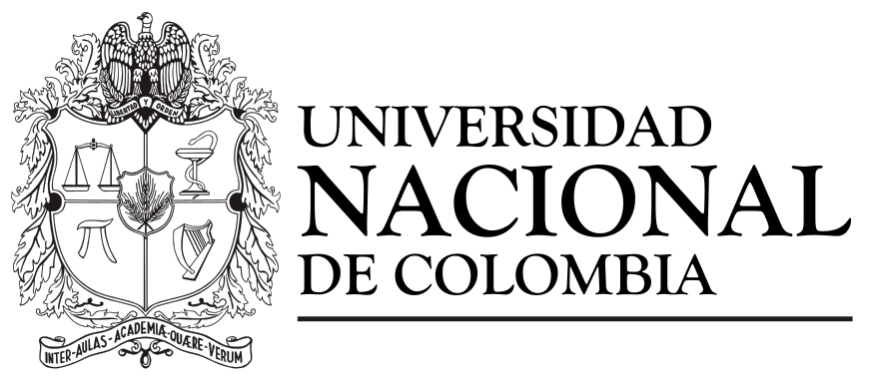

**Grupo 6**

Integrantes:

- Valentina Ospina Narváez - [vospinan@unal.edu.co](mailto:vospinan@unal.edu.co)
- Juan Pablo Pineda Lopera - [jppinedal@unal.edu.co](mailto:jppinedal@unal.edu.co)
- Juan Camilo Torres Arboleda - [jutorresar@unal.edu.co](mailto:jutorresar@unal.edu.co)

Semestre 2024 - 2

In [ ]:
!pip install markdown2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.2 MB/s eta 0:00:00


#Se importan las librerías

In [ ]:
#Librerias
import os
from google.colab import userdata
import google.generativeai as genai
import torch
import time
import logging
from transformers import BertTokenizer, BertModel
import torch
import textstat
from markdown2 import markdown

os.environ['API_KEY'] = userdata.get('API_KEY')


##En esta parte se carga un archivo PDF, se envia a la API de Google Gemini y se obtene un resumen del contenido del documento al seguir los siguientes pasos
- Librerías: Se importa genai para interactuar con la API de Google Gemini.

- Autenticación: Se crea un cliente utilizando una clave API almacenada en la variable de entorno API_KEY.

- Carga del PDF: Se sube un archivo PDF desde la ruta "/content/nombre del archivo.pdf".

- Generación del resumen: Se envía una solicitud al modelo de IA gemini-2.0-pro-exp-02-05 para obtener un resumen del archivo.

- Salida: Se imprime el resumen generado por la IA.

In [ ]:
#Generamos un resumen para pasarlo como promt al LLM con gemini
from google import genai
client = genai.Client(api_key=os.environ['API_KEY'])
sample_pdf = client.files.upload(file="/content/Programa_3006915.pdf")
response = client.models.generate_content(
    model="gemini-2.0-pro-exp-02-05",
    contents=["Give me a summary of this pdf file.", sample_pdf]
)
print(response.text)

This PDF document is a detailed syllabus for the Statistics II course (code 3006915) at the Universidad Nacional de Colombia, Medellín campus, for the 2024-02 semester. It covers the following key aspects:

**Course Content:** The course is divided into three main sections:

*   **I. Simple Linear Regression (SLR):**  Covers the fundamentals of SLR, including model estimation (using maximum likelihood and least squares), hypothesis testing, confidence intervals, ANOVA, R-squared, residual analysis, and transformations.
*   **II. Multiple Linear Regression (MLR):**  Expands on SLR to include multiple predictors.  Topics include matrix formulation, least squares estimation, hypothesis testing for individual and groups of coefficients, confidence intervals, residual analysis, multicollinearity, variable selection techniques, and indicator variables.
*   **III. Introduction to Sampling:** Introduces basic sampling concepts and techniques. It covers simple random sampling, stratified random

#Se carga el resumen de texto generado

In [ ]:
# Guardamos el resultado en un archivo de texto para suministrarlo como promt a Chatgpt
with open("resumenToGPT.txt", "w") as file:
    file.write(response.text)

#Configuración y generación del contenido


- Se importan genai, logging, time y os para la gestión de la API y registro de eventos.

- Se verifica la clave de API y se configura la conexión con Google Gemini.

- Se implementa un decorador rate_limited_request para controlar la cantidad de solicitudes por minuto.

- Se utiliza generate_content para procesar un prompt estructurado basado en metodología académica.

- Se carga el programa del curso, se genera el prompt y se obtiene un material educativo detallado.

In [ ]:
# 🔹 Configuración de logging para rastrear eventos y errores
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 🔹 Configuración de la API de Google Gemini con validación
GOOGLE_API_KEY = os.environ['API_KEY']
if not GOOGLE_API_KEY:
    raise ValueError("Error API key")

genai.configure(api_key=GOOGLE_API_KEY)

# 🔹 Gestión de tokens y limitación de tasa
MAX_REQUESTS_PER_MINUTE = 60
TIME_BETWEEN_REQUESTS = 60 / MAX_REQUESTS_PER_MINUTE

# 🔹 Modelo de generación de texto
MODEL_NAME = "models/gemini-2.0-pro-exp-02-05"

def rate_limited_request(func):
    """Decorador para limitar la tasa de llamadas a la API."""
    def wrapper(*args, **kwargs):
        time.sleep(TIME_BETWEEN_REQUESTS)  # Espera entre llamadas
        return func(*args, **kwargs)
    return wrapper

@rate_limited_request
def generate_content(prompt: str, config: dict):
    """Genera contenido utilizando la API de Gemini."""
    try:
        model = genai.GenerativeModel(MODEL_NAME)
        response = model.generate_content(prompt, generation_config=config)
        return response.text
    except Exception as e:
        logging.error(f"Error al generar contenido: {e}")
        return None

# Configuración de la generación con 0.2 de temperature para mantener respuestas precisas y deterministas
# y top_p para seleccionar tokens con mayor probabilidad acumulada, asegurando mayor coherencia (0-1)
# y top_k en 50 para limitar la cantidad de palabras candidatas y así evitar respuestas poco relevantes (0-100)
# y max_output_tokens para limitar la longitud de la respuesta generada
generation_config = {
    "temperature": 0.2,
    "top_p": 0.85,
    "top_k": 50,
    "max_output_tokens": 100000,
}


# 🔹 Prompt mejorado con enfoque metodológico y referencias
def create_prompt(course_syllabus: str):
    """
    1- Crea un prompt detallado para la generación de material educativo de alta calidad.
    """
    return f"""
    Usted es un experto desarrollador de contenidos educativos con amplia experiencia en la creación de materiales de nivel universitario.
    Su tarea consiste en generar un material de curso estructurado, riguroso y pedagógicamente sólido basado en el programa proporcionado.

    **Output Requirements:**
    - Clear section headings and numbering.
    - Deep theoretical explanations with academic references.
    - Detailed practical examples and project-based learning approaches.
    - Methodology recommendations (case studies, hands-on projects, peer discussions).
    - Potential challenges and mitigation strategies.
    - Verified academic references (papers, books, datasets, tools).


    2- Objetivo: Obtener una respuesta bien estructurada, detallada y alineada con estándares académicos.

    3- Estrategias clave:

    3.1- Especifica una respuesta con profundidad, metodología educativa y ejemplos detallados.
    3.2- Elabora títulos, secciones numeradas, listas detalladas y explicaciones paso a paso.
    3.3- Brinda la enseñanza con ejemplos reales y vinculación de teoría con práctica.
    3.4- Genera conntenido con rigor académico, fundamentación teórica, metodologías activas, análisis comparativo.

    4- Genera un material educativo estructurado en secciones claras y detalladas. Cada tema debe incluir:

    4.1- Explicación teórica con fundamentación académica.
    4.2- Ejemplos prácticos aplicados con implementación en código cuando sea relevante.
    4.3- Metodología de enseñanza recomendada (ej. aprendizaje basado en proyectos, estudio de casos, etc.).
    4.4- Posibles desafíos y estrategias para resolverlos.
    4.5- Recursos complementarios (artículos, libros, datasets, herramientas).

    5- Formato esperado:
    5.1- Secciones numeradas y organizadas.
    5.2- Texto explicativo con detalles técnicos y pedagógicos.
    5.3- Uso de ejemplos prácticos y estudios de caso.
    5.4- Explicaciones claras con referencias a papers o fuentes confiables."
    5.5- Evaluación y Refinamiento del Material Generado
    5.6- Objetivo: Mejorar la calidad del material mediante un proceso de revisión iterativa.

    6- Estrategias clave:

    6.1- Comparar el contenido con los objetivos del curso: Evaluar si la respuesta cubre todos los temas con la profundidad requerida.
    6.2- Revisar estructura y claridad: Asegurar que la información esté bien organizada y sea comprensible.
    6.3- Verificar calidad metodológica: Evaluar si se usan estrategias de enseñanza adecuadas.
    6.4- Identificar vacíos o áreas débiles: Detectar dónde faltan detalles, ejemplos o referencias.
    6.5- Refinar el prompt para corregir deficiencias detectadas.

    7- Incorporación de Referencias y Validación Académica
    8- Objetivo: Asegurar que el material esté respaldado por fuentes confiables y actualizadas.

    9- Estrategias clave:

    9.1- Realizar una búsqueda de referencias en bases de datos académicas: Google Scholar, IEEE Xplore, Springer, ResearchGate.
    9.2- Usar herramientas de IA para obtener citas confiables: Solicitar papers específicos en arXiv, Semantic Scholar o CORE.
    9.3- Verificar que las referencias sean recientes y relevantes: Priorizar fuentes publicadas en los últimos 5 años.
    9.4- Citar correctamente y enlazar a los documentos originales.
    9.5- Incluir recursos adicionales como datasets, libros, tutoriales y repositorios de código.
    **Course Syllabus:**
    {course_syllabus}
    """

# 🔹 Ejecución del proceso
if __name__ == "__main__":
    programaCurso = response.text
    prompt = create_prompt(programaCurso)
    logging.info("Generando contenido educativo...")

    generated_text = generate_content(prompt, generation_config)
    print("\n==== MATERIAL EDUCATIVO GENERADO ====")
    print(generated_text)
else:
    logging.error("No se pudo generar contenido.")



==== MATERIAL EDUCATIVO GENERADO ====
Okay, let's develop a comprehensive educational resource based on the Statistics II syllabus provided. We will follow a structured approach, incorporating theoretical explanations, practical examples, pedagogical recommendations, and academic rigor.

**Statistics II: A Comprehensive Course Material**

This course material is designed to align with the Statistics II (3006915) syllabus at the Universidad Nacional de Colombia, Medellín campus. It covers Simple Linear Regression, Multiple Linear Regression, and an Introduction to Sampling.

---

**I. Simple Linear Regression (SLR)**

**1.1 Introduction to Simple Linear Regression**

*   **Theoretical Explanation:**
    *   Simple Linear Regression (SLR) is a statistical method used to model the relationship between two continuous variables: a predictor variable (independent variable, typically denoted as *x*) and a response variable (dependent variable, typically denoted as *y*).  The goal is to find 

### Similitud Semántica con NLP


- BertTokenizer: Esta clase se encarga de convertir texto en tokens (unidades numéricas) que el modelo BERT puede entender.
- from_pretrained("bert-base-uncased"): Esta función descarga el vocabulario y la configuración del tokenizador pre-entrenado "bert-base-uncased".

- BertModel: Esta clase representa el modelo BERT en sí, la arquitectura neuronal que procesa los tokens.
- from_pretrained("bert-base-uncased"): Esta función descarga los pesos (parámetros) pre-entrenados del modelo "bert-base-uncased".

In [ ]:
# Cargar modelo BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")


# Se lee el archivo generado

In [ ]:
# leemos output gpt.txt
with open("/content/output gpt.txt", "r") as file:
    generated_text = file.read()

#print(generated_text)
#print(response.text)


# Métricas

# Funciones principales
- # Similitud semántica entre textos con embeddings de BERT.
  - Se carga el tokenizador y el modelo BERT preentrenado (bert-base-uncased).
  - Tokeniza ambos textos y los convierte en tensores de PyTorch.
  - Obtiene los embeddings de salida del modelo BERT.
  - Calcula la similitud coseno entre los vectores promedio de los embeddings.
  - Valor de salida: Un número entre -1 y 1, donde 1 indica alta similitud semántica.

- # Verificación de contradicciones en el contenido.
  - Divide el texto en oraciones y verifica si hay repeticiones exactas entre frases consecutivas.
  - Si hay repeticiones, cuenta como contradicción.
- # Evaluación de legibilidad mediante Flesch-Kincaid.
  - Utiliza la fórmula Flesch Reading Ease, que mide qué tan fácil es leer un texto.
  - Valor de salida:
  - 70-100 → Fácil de leer.
  - 50-70 → Comprensión moderada.
  - 0-50 → Difícil de leer.

- # Medición del uso de términos técnicos comparando con un glosario.
  - Evalúa un texto generado en comparación con un Gold Standard y un glosario técnico.

- # Métricas calculadas:
  - Relevancia: Comparación con el Gold Standard usando text_similarity.
  - Consistencia: Verifica contradicciones con check_contradictions.
  - Legibilidad: Evalúa la facilidad de lectura con readability_score.
  - Terminología: Mide el uso de términos técnicos con terminology_match.

- # Cálculo de coincidencias con palabras clave del estándar de referencia.
  - Compara las palabras clave del Gold Standard con las del texto generado.

In [ ]:

# Cargar modelo BERT para comparación semántica
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def text_similarity(text1, text2):
    """Calcula la similitud entre dos textos usando embeddings de BERT."""
    inputs = tokenizer([text1, text2], padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Promedio de los embeddings en todas las posiciones de los tokens
    embedding1 = outputs.last_hidden_state[0].mean(dim=0)
    embedding2 = outputs.last_hidden_state[1].mean(dim=0)

    # Similitud coseno
    similarity = torch.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))

    return similarity.item()

def check_contradictions(text):
    """Detecta contradicciones en el texto dividiéndolo en oraciones y verificando inconsistencias."""
    sentences = text.split(". ")
    contradictions = 0

    for i in range(len(sentences) - 1):
        if sentences[i] in sentences[i+1]:  # Busca repeticiones exactas
            contradictions += 1

    return 1 - (contradictions / max(len(sentences), 1))  # Cuanto más alto, más consistente

def readability_score(text):
    """Calcula el puntaje de legibilidad usando la fórmula Flesch-Kincaid."""
    return textstat.flesch_reading_ease(text)  # Devuelve un puntaje de 0 a 100 (100 es más fácil de leer)

def terminology_match(text, glossary):
    """Mide qué porcentaje del glosario técnico está presente en el texto generado."""
    words = text.lower().split()
    matched_terms = [word for word in glossary if word in words]
    return len(matched_terms) / max(len(glossary), 1)

def evaluate_content(text, gold_standard, glossary):
    """Evalúa el contenido generado utilizando métricas automatizadas."""
    if not text:
        return {"error": "No se generó contenido válido"}

    scores = {
        "relevancia": text_similarity(text, gold_standard),  # Comparación con un Gold Standard
        "consistencia": check_contradictions(text),  # Verifica repeticiones o contradicciones
        "legibilidad": readability_score(text),  # Fórmula Flesch-Kincaid
        "terminología": terminology_match(text, glossary),  # Comparación con glosario técnico
    }

    return scores

def keyword_match(generated_text, gold_standard_keywords): #Evalumos cuántos términos clave del "Gold Standard" aparecen en el texto generado
    words = generated_text.lower().split()
    matched_keywords = [word for word in gold_standard_keywords if word in words]
    return len(matched_keywords) / len(gold_standard_keywords)


#Generación de las métricas

In [ ]:
#generamos las metricas
similitud = text_similarity(generated_text, response.text)
consistencia = check_contradictions(generated_text)
legibilidad = readability_score(generated_text)
terminologia = terminology_match(generated_text, response.text)
palabras_clave = keyword_match(generated_text, response.text)

print(f'Similitud semántica: {similitud}')
print(f'Consistencia: {consistencia}')
print(f'Legibilidad: {legibilidad}')
print(f'Terminología: {terminologia}')
print(f'Palabras clave: {palabras_clave}')



Similitud semántica: 0.6978062987327576
Consistencia: 1.0
Legibilidad: 17.2
Terminología: 0.21823020625415834
Palabras clave: 0.21823020625415834


Conclusión
El texto generado por nuestro LLM (Gemini) es coherente y bien estructurado, pero tiene dos problemas principalmente: es demasiado técnico en su redacción y, al mismo tiempo, no usa suficientes términos especializados del área. Esto significa que, aunque el contenido es sólido, puede  mejorarse de acuerdo al público objetivo:
- hacerlo más accesible para quienes no son expertos
- enriquecerlo con más terminología técnica para hacerlo más preciso

Para mejorar estos resultados, se podría ajustar el prompt para especificar un nivel de detalle más alto en cuanto a vocabulario técnico, o modificar la configuración del modelo para hacer el texto más claro sin perder profundidad:
temperature, top_p, top_k, max_output_tokens.









In [ ]:
# Programa del curso en txt
with open("Programa del curso generado por LLM.txt", "w") as file:
    file.write(response.text)

# en un archivo Markdown
with open("Programa del curso generado por LLM.md", "w") as file:
    file.write(response.text)